# Welcome to the ProgPy Events Tutorial

#### `Event` is the term used to describe something to be predicted. Generally in the PHM community these are referred to as End of Life (EOL). However, they can be much more.

In progpy, events can be anything that needs to be predicted. Events can represent End of Life (EOL), End of Mission (EOM), warning thresholds, or any Event of Interest (EOI). 

This example demonstrates how events can be used in your applications.

### Importing Modules

In [27]:
import matplotlib.pyplot as plt
from progpy.loading import Piecewise
from progpy.models import BatteryElectroChemEOD

### Example) Warning Thresholds

In this example we will use the battery model. We of course are interested in end of discharge, but for this example we have a requirement that says the battery must not fall below 5% State of Charge (SOC)!

__Note__: SOC is the event state for the End of Discharge (EOD) event

Event states, like SOC go between 0 and 1, where 1 is healthy and at 0 the event has occurred. So, 5% SOC corresponds to an 'EOD' event state of 0.0.

Additionally, we have two warning thresholds (yellow and red)

In [28]:
YELLOW_THRESH = 0.15
RED_THRESH = 0.1
THRESHOLD = 0.05

#### Step 1: Extend the battery model to define the additional events

We will create a new class that extends from the BatteryElectroChemEOD Model and define the additional events!

In [29]:
class MyBatt(BatteryElectroChemEOD):
    events = BatteryElectroChemEOD.events + ['EOD_warn_yellow', 'EOD_warn_red', 'EOD_requirement_threshold']

Here, we are adding the warning thresholds to the BatteryElectroChemEOD Events.

Now, let us redefine `event_state()` and `threshold_met()` functions to accommodate for the new events that were added.

In [30]:
def event_state(self, state):
    # Get event state from parent
    event_state = super(MyBatt, self).event_state(state)

    # Add yellow, red, and failure states by scaling EOD state
    # Here we scale so the threshold SOC is 0 by their associated events, while SOC of 1 is still 1
    # For example, for yellow we want EOD_warn_yellow to be 1 when SOC is 1, and 0 when SOC is YELLOW_THRESH or lower
    event_state['EOD_warn_yellow'] = (event_state['EOD']-YELLOW_THRESH)/(1-YELLOW_THRESH) 
    event_state['EOD_warn_red'] = (event_state['EOD']-RED_THRESH)/(1-RED_THRESH)
    event_state['EOD_requirement_threshold'] = (event_state['EOD']-THRESHOLD)/(1-THRESHOLD)

    # Return
    return event_state

In [31]:
def threshold_met(self, x):
    # Get threshold met from parent
    t_met = super(MyBatt, self).threshold_met(x)

    # Add yell and red states from event_state
    event_state = self.event_state(x)
    t_met['EOD_warn_yellow'] = event_state['EOD_warn_yellow'] <= 0
    t_met['EOD_warn_red'] = event_state['EOD_warn_red'] <= 0
    t_met['EOD_requirement_threshold'] = event_state['EOD_requirement_threshold'] <= 0

    return t_met

### Let's test the newly constructed model!

In [32]:
m = MyBatt()

Now, we have to define the future_loading function to simulate the results of our model!

We'll use a variable (piece-wise) future loading scheme. For a battery, future loading is in term of current 'i' in amps. 

In [33]:
future_loading = Piecewise(
    m.InputContainer,
    [600, 900, 1800, 3000, float('inf')],
    {'i': [2, 1, 4, 2, 3]})

Finally, let's simulate our results to threshold!

In [36]:
simulated_results = m.simulate_to_threshold(future_loading, threshold_keys=['EOD', 'EOD_warn_yellow'], print = True)

Time: 0.0
	Input: {'i': 2.0}
	State: {'tb': 292.1, 'Vo': 0.0, 'Vsn': 0.0, 'Vsp': 0.0, 'qnB': 6840.0, 'qnS': 760.0, 'qpB': 4560.000000000001, 'qpS': 506.6666666666668}
	Output: {'t': 18.950000000000045, 'v': 4.191350293826752}
	Event State: {'EOD': 1.0}



KeyError: 'EOD_warn_yellow'

Great, let's plot our simulated results and see how the events change overtime!

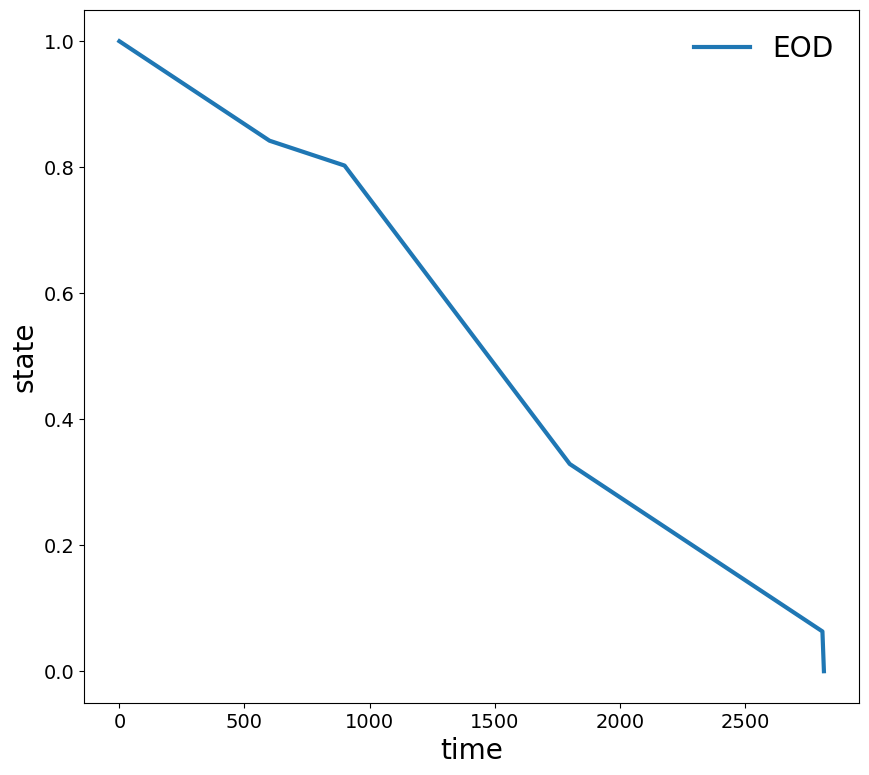

In [35]:
simulated_results.event_states.plot()
plt.show()